In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

np.random.seed(42)

## 1. Загрузка данных

Загрузим данные и словарь меток классов, используя [инструкцию](https://www.cs.toronto.edu/~kriz/cifar.html).

In [8]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

raw_data = [unpickle(f'./cifar-10-batches-py/data_batch_{batch}') for batch in range(1, 6)]
raw_data.append(unpickle(f'./cifar-10-batches-py/test_batch'))
all_objects = []
all_labels = []
for batch in raw_data:
    all_objects.extend(np.asarray(batch[b'data']))
    all_labels.extend(np.asarray(batch[b'labels']))

label_names = unpickle(f'./cifar-10-batches-py/batches.meta')[b'label_names']
label_names = [name.decode("utf-8") for name in label_names]

print(f'Images total count: {len(all_objects)}')

Images total count: 60000


Посмотрим на первые несколько изображений из датасета.

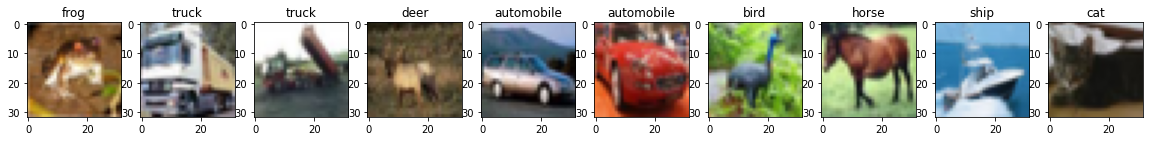

In [3]:
def row_to_image(row):
    result = np.empty((32, 32, 3), dtype='uint8')
    for i in range(3072):
        result[i % 1024 // 32][i % 1024 % 32][i // 1024] = row[i]
    return result


def draw_image(data, label, axes):
    data = row_to_image(data)
    img = Image.fromarray(data)
    axes.set_title(label)
    axes.imshow(img)


FIRST_OBJECT_TO_DRAW = 10
fig, axes = plt.subplots(1, FIRST_OBJECT_TO_DRAW, figsize=(2 * FIRST_OBJECT_TO_DRAW, 3))

for image_index in range(FIRST_OBJECT_TO_DRAW):
    draw_image(all_objects[image_index], label_names[all_labels[image_index]], axes[image_index])

Определим класс для загрузки данных и правильных ответов.

In [4]:
all_objects = (np.array(all_objects) / 255).astype('float32')
x_train, x_test, y_train, y_test = train_test_split(all_objects, all_labels, test_size=0.2, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.2, random_state=0)

class DataLoader:
    """Class for loading data in batches"""

    def __init__(self, objects, labels, batch_size):
        self.objects = np.array(objects)
        self.one_hot_encoder = OneHotEncoder()
        self.labels = self.one_hot_encoder.fit_transform(np.array(labels).reshape(-1, 1)).toarray()
        self.batch_size = batch_size
        self.counter = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.counter >= len(self.objects):
            raise StopIteration

        batch = self.objects[self.counter: self.counter + self.batch_size],\
                self.labels[self.counter: self.counter + self.batch_size]
        self.counter += self.batch_size
        return batch

    def __len__(self):
        batch_amount = self.get_objects_count() // self.batch_size
        if batch_amount * self.batch_size < len(self.objects):
            batch_amount += 1
        return batch_amount

    def get_objects_count(self):
        return self.objects.shape[0]


loader = DataLoader(x_train, y_train, 3)
print(len(loader))
print(next(loader))

16000
(array([[0.05490196, 0.09803922, 0.14509805, ..., 0.19215687, 0.19607843,
        0.16470589],
       [0.6666667 , 0.59607846, 0.5529412 , ..., 0.44313726, 0.48235294,
        0.4627451 ],
       [0.65882355, 0.6431373 , 0.64705884, ..., 0.43137255, 0.3764706 ,
        0.27450982]], dtype=float32), array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]))


Основной класс нейронной сети.

In [10]:
from regularization import l1_regularization, l1_regularization_d
from activation_functions import re_lu, re_lu_d

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1).reshape(-1, 1))
    softmax = e_x / e_x.sum(axis=1).reshape(-1, 1)
    return softmax

class Layer:
    """
    Container for weights for single layer.
    """
    def __init__(self, w, b):
        self.w = w
        self.b = b


class NeuralNet:
    """
    Class for neural nets.
    Input layout: every row corresponds to a single batch, columns correspond to input features.
    After applying any hidden layer we get the same layout (rows are batches, columns are hidden features).
    """
    def __init__(self, layer_sizes, lr, lambda_ = 0.1, input_dropout_prob = 0.8, hidden_dropout_prob = 0.5, activation=re_lu):
        self.layer_sizes = layer_sizes
        self.lr = lr
        self.lambda_ = lambda_
        self.input_dropout_prob = input_dropout_prob
        self.hidden_dropout_prob = hidden_dropout_prob
        self.activation = activation

        np.random.seed(42)

        self.layers = []
        # First layer is input layer without weights
        self.layers.append(Layer(None, None))
        for l in range(1, len(layer_sizes)):
            w = np.zeros((layer_sizes[l - 1], layer_sizes[l]))
            b = np.zeros((1, layer_sizes[l]))
            self.layers.append(Layer(w, b))

        self.initialize_weights()

        self.Z = [None] * len(layer_sizes)
        self.dropout_masks = [None] * len(layer_sizes)
        self.A = [None] * len(layer_sizes)

        self.state = 'train'

    def get_weights(self):
        result = {}
        for i, layer in enumerate(self.layers):
            if i > 0:
                result[f'w_{i}'] = layer.w
                result[f'b_{i}'] = layer.b
        return result

    def set_weights(self, weights_dict):
        for i, layer in enumerate(self.layers):
            if i > 0:
                layer.w = weights_dict[f'w_{i}']
                layer.b = weights_dict[f'b_{i}']

    def set_state(self, state):
        self.state = state

    def initialize_weights(self):
        for i, layer in enumerate(self.layers):
            if i > 0:
                layer.w = np.random.randn(*layer.w.shape) * np.sqrt(1. / self.layer_sizes[i])

    def forward(self, X):
        self.A[0] = X
        if self.state == 'train':
            self.A[0], self.dropout_masks[0] = self.dropout(self.A[0], self.input_dropout_prob)
        else:
            self.A[0] *= self.input_dropout_prob

        for i in range(1, len(self.layers) - 1):
            layer = self.layers[i]
            self.Z[i] = np.dot(self.A[i - 1], layer.w) + layer.b
            if self.state == 'train':
                self.Z[i], self.dropout_masks[i] = self.dropout(self.Z[i], self.hidden_dropout_prob)
            else:
                self.Z[i] *= self.hidden_dropout_prob
            self.A[i] = self.activation(self.Z[i])

        last_layer_index = len(self.layers) - 1
        self.Z[last_layer_index] = np.dot(self.A[last_layer_index - 1], self.layers[last_layer_index].w) + self.layers[last_layer_index].b
        self.A[last_layer_index] = softmax(self.Z[last_layer_index])

        return self.A[last_layer_index]

    def dropout(self, Z, prob):
        mask = np.random.binomial(1, prob, size=Z.shape)
        result = np.multiply(Z, mask)
        return result, mask

    def loss(self, y_pred, y_true):
        # Weston & Watkins hinge loss https://en.wikipedia.org/wiki/Hinge_loss
        result = []
        for batch_index in range(len(y_pred)):
            y_pred_for_batch = y_pred[batch_index]
            y_true_for_batch = y_true[batch_index]
            correct_class_index = -1
            for class_index, pred_prob in enumerate(y_true_for_batch):
                if pred_prob == 1:
                    correct_class_index = class_index
            pred_prob_for_correct_class = y_pred[batch_index][correct_class_index]

            object_loss = 0
            for class_index, pred_prob in enumerate(y_pred_for_batch):
                if class_index != correct_class_index:
                    object_loss += max(0, 1 + pred_prob - pred_prob_for_correct_class)

            result.append(object_loss)

        batch_loss = np.mean(np.array(result))

        regularization_term = l1_regularization(dict2vector(self.get_weights())[0])

        return batch_loss + self.lambda_ * regularization_term

    def backward(self, X, y_pred, y_true):
        n_samples = y_true.shape[0]
        last_layer_index = len(self.layers) - 1

        dA = [None] * len(self.layers)
        dZ = [None] * len(self.layers)
        dw = [None] * len(self.layers)
        db = [None] * len(self.layers)

        dZ[last_layer_index] = []
        for batch_index in range(len(y_pred)):
            y_true_for_batch = y_true[batch_index]
            y_pred_for_batch = y_pred[batch_index]
            correct_class_index = -1
            for class_index, prob in enumerate(y_true_for_batch):
                if prob == 1:
                    correct_class_index = class_index
            pred_prob_for_correct_class = y_pred_for_batch[correct_class_index]

            last_layer_output_size = self.layer_sizes[last_layer_index]
            d = [last_layer_output_size * pred_prob * (pred_prob - 1) if class_index == correct_class_index
                 else last_layer_output_size * pred_prob * pred_prob_for_correct_class
                 for class_index, pred_prob in enumerate(y_pred_for_batch)]
            dZ[last_layer_index].append(d)

        dZ[last_layer_index] = np.array(dZ[last_layer_index])

        dw[last_layer_index] = np.dot(self.A[last_layer_index - 1].T, dZ[last_layer_index])
        db[last_layer_index] = np.sum(dZ[last_layer_index], axis=0, keepdims=True)

        for i in range(last_layer_index - 1, 0, -1):
            dA[i] = np.dot(dZ[i + 1], self.layers[i + 1].w.T)
            dZ[i] = np.multiply(dA[i], re_lu_d(self.Z[i]))
            dZ[i] = np.multiply(dZ[i], self.dropout_masks[i])

            dw[i] = np.dot(self.A[i - 1].T, dZ[i])
            db[i] = np.sum(dZ[i], axis=0, keepdims=True)

        gradient_dict = {}
        for i, layer in enumerate(self.layers):
            if i > 0:
                gradient_dict[f'dw_{i}'] = dw[i] / n_samples + self.lambda_ * l1_regularization_d(layer.w)
                gradient_dict[f'db_{i}'] = db[i] / n_samples + self.lambda_ * l1_regularization_d(layer.b)
        return gradient_dict

    def update_weights(self, gradient_dict):
        for i, layer in enumerate(self.layers):
            if i > 0:
                self.layers[i].w -= self.lr * gradient_dict[f'dw_{i}']
                self.layers[i].b -= self.lr * gradient_dict[f'db_{i}']

## 3. Проверка корректности расчета обратного распространения ошибки

In [155]:
def check_backprop(X, y, epsilon=1e-7):
    model = NeuralNet(layer_sizes=[X.shape[1], 15, y.shape[1]], lr=0.01, lambda_=0, input_dropout_prob=1, hidden_dropout_prob=1)

    numeric_gradient_flatten = []
    params_flatten, params_shape = dict2vector(model.get_weights())

    for i in range(len(params_flatten)):
        params_copy_flatten = np.copy(params_flatten)
        params_copy_flatten[i] -= epsilon
        model.set_weights(vector2dict(params_copy_flatten, params_shape))
        pred_with_decreased_param = model.forward(X)
        loss_with_decreased_param = model.loss(pred_with_decreased_param, y)

        params_copy_flatten = np.copy(params_flatten)
        params_copy_flatten[i] += epsilon
        model.set_weights(vector2dict(params_copy_flatten, params_shape))
        pred_with_increased_param = model.forward(X)
        loss_with_increased_param = model.loss(pred_with_increased_param, y)

        numerical_derivative_flatten = (loss_with_increased_param - loss_with_decreased_param) / (2 * epsilon)
        numeric_gradient_flatten.append(numerical_derivative_flatten)

    numeric_gradient_flatten = np.array(numeric_gradient_flatten)

    params_copy_flatten = np.copy(params_flatten)
    model.set_weights(vector2dict(params_copy_flatten, params_shape))
    pred = model.forward(X)
    analytical_gradient = model.backward(X, pred, y)
    analytical_gradient_flatten, _ = dict2vector(analytical_gradient)

    print(f'Numerical solution norm: {np.linalg.norm(numeric_gradient_flatten)}')
    print(f'Analytical solution (backpropagation) norm:  {np.linalg.norm(analytical_gradient_flatten)}')

    diff =  np.linalg.norm(numeric_gradient_flatten - analytical_gradient_flatten) / (np.linalg.norm(numeric_gradient_flatten) + np.linalg.norm(analytical_gradient_flatten))

    if diff > epsilon:
        print('Backprop is incorrect!')
    else:
        print('Backprop is correct!')
    return diff

batch_loader = DataLoader(x_train, y_train, 16)
x, y = next(batch_loader)
check_backprop(x, y, 1e-7)

Numerical solution norm: 5.887328383352875
Analytical solution (backpropagation) norm:  5.887328348674413
Backprop is correct!


8.33217719574942e-08

In [157]:
def gradient_scale_check(X, y, lr):
    model = NeuralNet(layer_sizes=[X.shape[1], 15, y.shape[1]], lr=lr, lambda_=0, input_dropout_prob=1, hidden_dropout_prob=1)
    y_pred = model.forward(X)

    param_scale = np.linalg.norm(dict2vector({'w_1': model.get_weights()['w_1']})[0])

    gradient_dict = model.backward(X, y_pred, y)
    weight_update = -lr * dict2vector({'dw_1': gradient_dict['dw_1']})[0]
    update_scale = np.linalg.norm(weight_update)

    scale = update_scale / param_scale

    if 1e-4 <= scale <= 1e-2:
        print('Gradient scale is correct!')
    else:
        print('Gradient scale is incorrect!')
    return scale


batch_loader = DataLoader(x_train, y_train, 16)
x, y = next(batch_loader)
gradient_scale_check(x, y, 0.03)

Gradient scale is correct!


0.0023302423765313497

In [14]:
def get_accuracy(y_pred, y_true):
    y_pred == y_true


def get_accuracy_test():



get_accuracy_test()

0.25


## 4. Цикл обучения

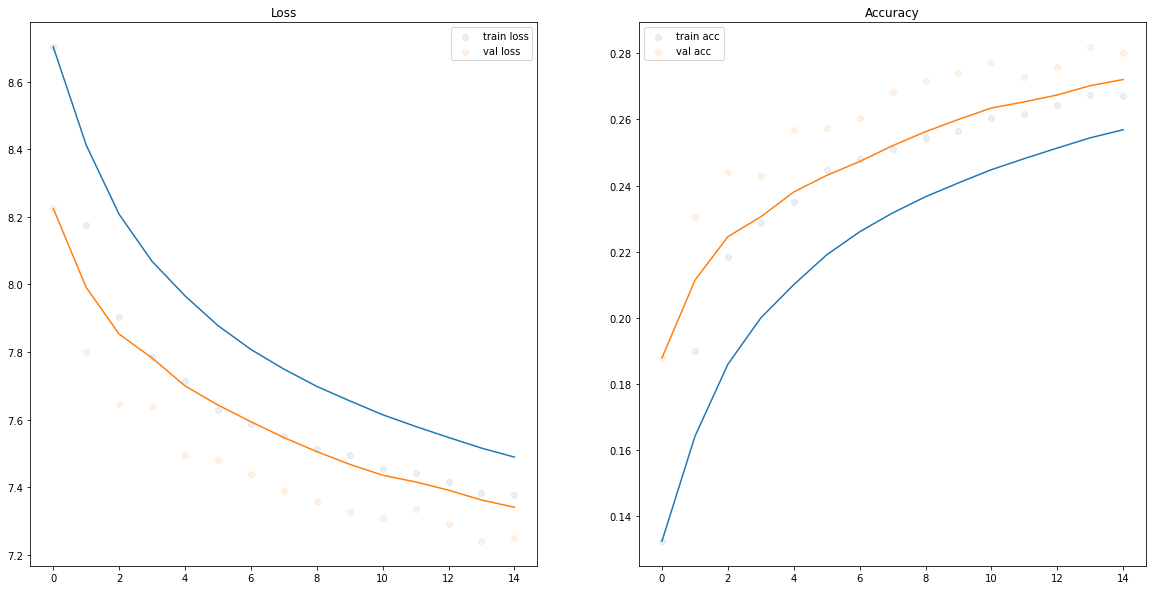

100%|██████████| 15/15 [01:54<00:00,  7.61s/it]


In [152]:
import pandas as pd
from tqdm import tqdm
from IPython.core.display_functions import clear_output
import matplotlib.pylab as plt
from utils import dict2vector, vector2dict

EPOCH_COUNT = 15
BATCH_SIZE = 100
LAYER_SIZES = [3072, 64, 10]
LEARNING_RATE = 0.01
REGULARIZATION_LAMBDA = 0.00
INPUT_DROPOUT_PROBA = 1
HIDDEN_DROPOUT_PROBA = 0.7

model = NeuralNet(layer_sizes=LAYER_SIZES, lr=LEARNING_RATE, lambda_=REGULARIZATION_LAMBDA,
                  input_dropout_prob=INPUT_DROPOUT_PROBA, hidden_dropout_prob=HIDDEN_DROPOUT_PROBA)

train_epoch_loss_array, train_epoch_acc_array = [], []
val_epoch_loss_array, val_epoch_acc_array = [], []

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values


def visualize_epoch_results(train_epoch_loss_array, val_epoch_loss_array):
    clear_output(True)
    plt.figure(figsize=[20, 10])
    plt.subplot(1, 2, 1), plt.title('Loss')
    plt.scatter(np.arange(len(train_epoch_loss_array)), train_epoch_loss_array, alpha=0.1, label='train loss')
    plt.plot(ewma(train_epoch_loss_array, span=10))
    plt.legend()
    plt.subplot(1, 2, 2), plt.title('Accuracy')
    plt.scatter(np.arange(len(train_epoch_acc_array)), train_epoch_acc_array, alpha=0.1, label='train acc')
    plt.plot(ewma(train_epoch_acc_array, span=10))
    plt.legend()
    plt.subplot(1, 2, 1)
    plt.scatter(np.arange(len(val_epoch_loss_array)), val_epoch_loss_array, alpha=0.1, label='val loss')
    plt.plot(ewma(val_epoch_loss_array, span=10))
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.scatter(np.arange(len(val_epoch_acc_array)), val_epoch_acc_array, alpha=0.1, label='val acc')
    plt.plot(ewma(val_epoch_acc_array, span=10))
    plt.legend()

    plt.show()


for epoch in tqdm(range(EPOCH_COUNT)):
    train_epoch_loss, train_epoch_acc = 0, 0
    model.set_state('train')
    train_dataloader = DataLoader(x_train, y_train, BATCH_SIZE)
    val_dataloader = DataLoader(x_val, y_val, BATCH_SIZE)

    for train_batch_x, train_batch_y in train_dataloader:
        train_batch_pred = model.forward(train_batch_x)
        train_batch_loss = model.loss(train_batch_pred, train_batch_y)
        gradient = model.backward(train_batch_x, train_batch_pred, train_batch_y)
        model.update_weights(gradient)

        train_epoch_loss += train_batch_loss
        train_epoch_acc += get_accuracy(train_batch_pred, train_batch_y)

    train_epoch_loss_array.append(train_epoch_loss / len(train_dataloader))
    train_epoch_acc_array.append(train_epoch_acc / len(train_dataloader))

    val_epoch_loss, val_epoch_acc = 0, 0
    model.set_state('test')
    for x_batch, y_batch in val_dataloader:
        batch_pred = model.forward(x_batch)
        val_batch_loss = model.loss(batch_pred, y_batch)

        val_epoch_loss += val_batch_loss
        val_epoch_acc += get_accuracy(batch_pred, y_batch)
    val_epoch_loss_array.append(val_epoch_loss / len(val_dataloader))
    val_epoch_acc_array.append(val_epoch_acc / len(val_dataloader))

    visualize_epoch_results(train_epoch_loss_array, val_epoch_loss_array)

## 5. Валидация

In [50]:
from sklearn.metrics import classification_report

test_dataloader = DataLoader(x_test, y_test, BATCH_SIZE)

predicted_labels = []
true_labels = []

model.set_state('test')
for x_batch, y_batch in test_dataloader:
  prediction_for_batch = model.forward(x_batch)

  predicted_labels_for_batch = np.argmax(prediction_for_batch, axis=1)
  true_labels_for_batch = np.argmax(y_batch, axis=1)

  predicted_labels.append(predicted_labels_for_batch)
  true_labels.append(true_labels_for_batch)

prediction = np.concatenate(predicted_labels)
label = np.concatenate(true_labels)

result = (prediction == label).mean()

print('Accuracy: ', result)
print(classification_report(label, prediction, target_names=label_names, zero_division=0))

Accuracy:  0.3541666666666667
              precision    recall  f1-score   support

    airplane       0.47      0.41      0.44       258
  automobile       0.39      0.31      0.35       239
        bird       0.24      0.33      0.28       243
         cat       0.00      0.00      0.00       250
        deer       0.33      0.40      0.37       234
         dog       0.29      0.41      0.34       239
        frog       0.35      0.42      0.38       218
       horse       0.43      0.24      0.31       249
        ship       0.36      0.61      0.45       230
       truck       0.43      0.43      0.43       240

    accuracy                           0.35      2400
   macro avg       0.33      0.36      0.33      2400
weighted avg       0.33      0.35      0.33      2400

